# Import des librairies


In [0]:
import numpy as np
import cv2
from math import log2, sqrt, pi, exp
from random import gauss
from random import randint

# Fonctions utiles au TD (fichier Tools)
On fournit ici les transformations de Peano

In [0]:
def bruit_gauss(signal, w, m1, sig1, m2, sig2):
    """
    Cette fonction permet de bruiter un signal discret à deux classes avec deux gaussiennes
    :param signal: Le signal a bruiter (un numpy array d'int)
    :param w: vecteur dont la première composante est la valeur de la classe 1 et la deuxième est la valeur de la classe 2
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: le signal bruité (numpy array de float)
    """
    noisy_signal = (signal==w[0]) * np.random.normal(m1, sig1, signal.size) + \
    (signal==w[1]) * np.random.normal(m2, sig2, signal.size)
    return noisy_signal

def gauss_dens(y, m, sig) :
  return (1/sqrt(2*pi)*sig)*np.exp(-((y-m)**2)/2)

def gauss(signal_noisy, m1, sig1, m2, sig2):
    """
    Cette fonction transforme le signal bruité per les densité des deux gaussiennes du bruit
    :param signal_noisy: Le signal bruité (numpy array 1D)
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément de signal noisy
    gauss[i,j] = P(Y=i | X=j)
    """
    v1 = ( 1 / (sig1*sqrt(2*pi)) ) * np.exp( -1/2 * ( (signal_noisy - m1)/sig1 )**2 )
    v2 = ( 1 / (sig2*sqrt(2*pi)) ) * np.exp( -1/2 * ( (signal_noisy - m2)/sig2 )**2 )
    return np.stack((v1, v2), axis=1)


def calc_erreur(signal1, signal2):
    """
    Cette fonction permet de mesurer la difference entre deux signaux discret (de même taille) à deux classes
    :param signal1: le premier signal, un numpy array
    :param signal2: le deuxième signal, un numpy array
    :return: La différence entre les deux signaux (un float)
    """
    err = np.sum(signal1 != signal2)/np.prod(signal2.shape)
    return err


def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
            (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
            (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp],dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x,y


def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0]==img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donne rune image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize==int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize,dSize))
    img[idx[0], idx[1]] = signal
    return img


def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]


def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0]==img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize==int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize,dSize))
    img[idx[0], idx[1]] = signal
    return img

# Test : Génération d'un vecteur aléatoire à deux classes

In [31]:
def random_vect(n, w) :
  return np.array([w[randint(0, 1)] for i in range(n)])
print("Test du générateur aléatoire \n")
w = [0, 1]
test = random_vect(20, w)

noi_sig = bruit_gauss(test, w, 2, 2, 4,2)
print("orignal signal : ", test, "\nnoisysignal : ", noi_sig)

print("\nerror = %f" %(calc_erreur(test, noi_sig)))

Test du générateur aléatoire 

orignal signal :  [0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1] 
noisysignal :  [-2.89773729  2.88124041  0.73999087  3.16425381  2.03918817  3.80385077
  0.78209988  3.37373977  2.7731827   4.23158921  3.80966605  2.2501166
  3.76407611  2.14627061  1.91245184  3.17325201  4.5582422   4.67723955
  4.51840097  1.52865793]

error = 1.000000


# Stratégie de Segmentation : 
Nous appliquons une démarche de **Segmentation bayésienne** non supervisée. Notre estimateur bayésien sera l'estimateur MPM (Mode Postérieur Maximum) : <br/>
$\hat{x_n}_{MPM}=\underset{x' \in \Omega}{\operatorname{argmax}}p(x' | y) $

Afin de calculer la loi à postériori $p(x | y) $, nous utiliserons la loi de Bayes, d'où le nom de la méthode : $p(x | y) = \frac{p(y | x)p(x)}{p(y)}$ <br/>

Ce calcul s'obtient très aisément dans le cadre des chaînes de markov grâce aux algorithmes *forward* et *backward*

# Implémentation des algorithmes Forward et Backward :
Dans un cadre markovien, on utilise les algorithmes forward et backward nécessaires à l'estimation des lois marginales conditionnelles aux observations : les $p(x_i | y_{1:N})$ (*probabilités à postériori*)

In [0]:
def forward(A, p, gauss):
    """
    Cette fonction calcule récursivement (mais ce n'est pas une fonction récursive!) les valeurs forward de la chaîne
    :param A: Matrice (2*2) de transition de la chaîne
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param gauss: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément du signal bruité
    :return: un vecteur de taille la longueur de la chaîne, contenant tous les forward (de 1 à n)
    """
    n = len(gauss)
    alpha = np.zeros((n, 2))
    alpha[0] = p*gauss[0]
    alpha[0]= alpha[0] / (alpha[0].sum())
    for i in range(1, n) :
      alpha[i] = gauss[i]* (alpha[i-1] @ A)
      alpha[i] = alpha[i] / (alpha[i].sum())# ajouté afin de résoudre les pb d'arrondi numérique
    return alpha


def backward(A, gauss):
    """
    Cette fonction calcule récursivement (mais ce n'est pas une fonction récursive!) les valeurs backward de la chaîne
    :param A: Matrice (2*2) de transition de la chaîne
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param gauss: numpy array (longeur de signal_noisy)*2 qui correspond aux valeurs des densité gaussiennes pour chaque élément du signal bruité
    :return: un vecteur de taille la longueur de la chaîne, contenant tous les backward (de 1 à n).
    Attention, si on calcule les backward en partant de la fin de la chaine, je conseille quand même d'ordonner le vecteur backward du début à la fin
    """
    n = len(gauss)
    beta = np.zeros((n, 2))
    beta[n-1] = np.ones(2)
    for i in reversed(range(0, n-1)) :
      beta[i] = A @ (beta[i+1] * gauss[i+1])
      beta[i] = beta[i] / (beta[i].sum())
    return beta


def mpm_mc(signal_noisy, w, p, A, m1, sig1, m2, sig2):
    """
     Cette fonction permet d'appliquer la méthode mpm pour retrouver notre signal d'origine à partir de sa version bruité et des paramètres du model.
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    n = len(gausses)
    alpha = forward(A,p,gausses)
    beta = backward(A,gausses)
    proba_apost = alpha*beta
    proba_apost = proba_apost / proba_apost.sum(axis=1)[..., np.newaxis] #numpy ne peut pas diviser un vecteur (n,2) par un vecteur (n), donc on transforme la somme en vecteur (n,2) avec la syntaxe [..., np.newaxis] (newaxis ajoute une colonne)
    #print(proba_apost)
    return w[np.argmax(proba_apost, axis=1)]


def calc_probaprio_mc_freq(signal, w):
    """
    Fonction perso :
    Cete fonction permet de calculer les probabilité a priori des classes w1 et w2 et les transitions a priori d'une classe à l'autre,
    en observant notre signal non bruité
    :param signal: Signal discret non bruité à deux classes (numpy array 1D d'int)
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :return: un vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    """
    p1 = np.sum(signal==w[0]) / signal.shape[0]
    p2 = np.sum(signal==w[1]) / signal.shape[0]
    p = np.array([p1, p2])
    A = np.zeros((2,2))
    for i in range(len(signal)-1) :
      if signal[i] == w[0] and signal[i+1]== w[0] :
        A[0][0]+=1
      elif signal[i] == w[0] and signal[i+1] == w[1] :
        A[0][1] +=1
      elif signal[i] == w[1] and signal[i+1] == w[0] :
        A[1][0] +=1
      elif signal[i] == w[1] and signal[i+1] == w[1] :
        A[1][1] +=1
        # penser à diviser A par les p qui conviennent
    return A

def calc_probaprio_mc(signal, w):
    """
    Cete fonction permet de calculer les probabilité a priori des classes w1 et w2 et les transitions a priori d'une classe à l'autre,
    en observant notre signal non bruité
    :param signal: Signal discret non bruité à deux classes (numpy array 1D d'int)
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :return: un vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    """
    p1 = np.sum(signal==w[0]) / signal.shape[0]
    p2 = np.sum(signal==w[1]) / signal.shape[0]
    p = np.array([p1, p2])
    C = sum([np.array([[(signal[i] == k and signal[i+1] ==l) for l in w] for k in w]) for i in range(signal.shape[0]-1)])
    C = C / signal.shape[0] # On divise par le nombre d'observations pour obtenir les fréquences
    A = (C.T/p).T #On divise la proba du couple par la proba marginale afin d'obtenir la conditionnelle
    return A

def simu_mc(n, w, p, A):
    """
    Cette fonction permet de simuler un signal discret à 2 classe de taille n à partir des probabilité d'apparition des deux classes et de la Matrice de transition
    :param n: taille du signal
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    simu = np.zeros((n,), dtype=int)
    aux = np.random.multinomial(1, p)
    simu[0] = w[np.argmax(aux)]
    for i in range(1, n):
        aux = np.random.multinomial(1, A[np.where(w == simu[i - 1])[0][0], :])
        simu[i] = w[np.argmax(aux)]
    return simu

Testons nos fonctions sur de petites simulations :
Nous utiliserons l'estimateur **MPM** plus adapté au traitement d'images car il permet de pénaliser les erreurs localement.



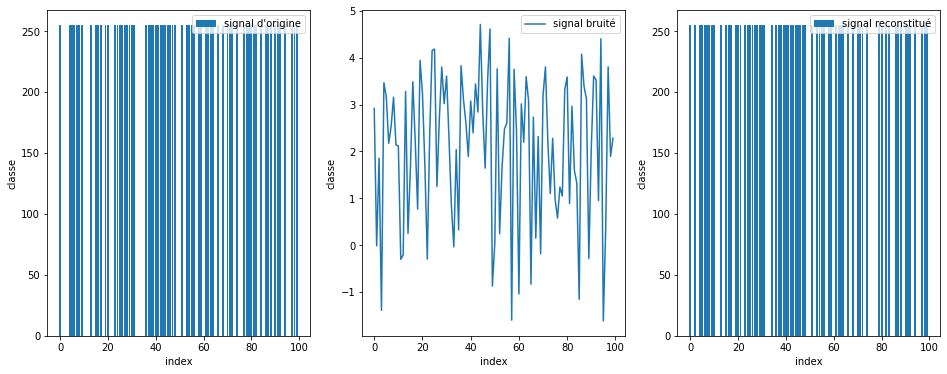

La segmentation affiche un taux d'erreur de 0.090000 


0.09

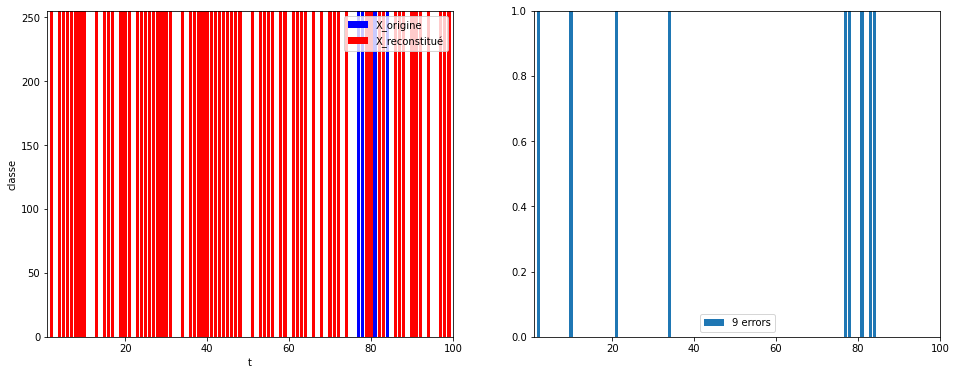

In [33]:
import matplotlib.pyplot as plt

#Paramètres :
A = np.array([[0.5, 0.5], [0.3, 0.7]])
w = np.array([0, 255])
p = np.array([0.3, 0.7])
n = 100
m = [0, 3]
sig = [1, 1]

def simu(n, w, p, A, m, sig, display=False) :
  #Signaux :
  signal = simu_mc(n, w, p, A) # génération de la chaine de Markov
  noisy_signal = bruit_gauss(signal, [0, 255], m[0], sig[0], m[1], sig[1]) # bruitage du signal avec un bruit gaussien
  signal_seg = mpm_mc(noisy_signal, w, p, A, m[0], sig[0], m[1], sig[1]) # segmentation du signal
  n_err = sum(signal != signal_seg)
  if display :
    plt.figure(figsize=(16,6))
    plt.subplot(1, 3, 1)
    plt.bar(np.arange(0, len(signal)), signal, label="signal d'origine")
    plt.xlabel("index")
    plt.ylabel("classe")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, len(signal)), noisy_signal, label="signal bruité")
    plt.xlabel("index")
    plt.ylabel("classe")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.bar(np.arange(0, len(signal)), signal_seg, label="signal reconstitué")
    plt.xlabel("index")
    plt.ylabel("classe")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(0, len(signal)), signal, color ='b', label='X_origine')
    plt.bar(np.arange(0, len(signal)), signal_seg, color ='r', label='X_reconstitué')
    plt.xlabel("t")
    plt.ylabel("classe")
    plt.axis([1, n, w[0], w[1]])
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(0, len(signal)), signal != signal_seg, label = "%d errors" % (n_err))
    plt.legend()
    plt.axis([1, n, 0, 1])
    plt.plot()
    print("La segmentation affiche un taux d'erreur de %f " %(n_err/n))

  return n_err/n

simu(n, w, p, A, m, sig, display=True)

# Tests 

In [34]:
m1 = [0, 3]
sig1 = [1, 2]
A1 = np.array([[0.5, 0.5], [0.3, 0.7]])

m2 = [1, 1]
sig2 = [1, 5]
A2 = np.array([[0.1, 0.9], [0.2, 0.8]])

m3= [0, 1]
sig3=[1, 1]
A3 = np.array([[0.7, 0.3], [0.4, 0.6]])

err1 = 0
for i in range(200) :
  err1 += simu(50, w, p, A1, m1, sig1)
t_err_1 = err1/200
print("cas n°1 : ", t_err_1)
simu(1000, w, p, A1, m1, sig1) # On vérifie qu'on a le même genre de résultats

err2 = 0
for i in range(200) :
  err2 += simu(50, w, p, A2, m2, sig2)
t_err_2 = err2/200
print("cas n°2 : ", t_err_2)

err3 = 0
for i in range(200) :
  err3 += simu(50, w, p, A3, m3, sig3)
t_err_3 = err3/200
print("cas n°3 : ", t_err_3)

cas n°1 :  0.151
cas n°2 :  0.1720999999999998
cas n°3 :  0.29290000000000016


| Tentative n° | taux d'erreur pour n=1000|
| :-----------| -------------------------:|
| 1| 0.309|
|2 | 0.1878|
|3 | 0.290|

In [35]:
signal = simu_mc(n, w, p, A)
A = calc_probaprio_mc(signal, w)
#print(signal)
print(A)

[[0.46511628 0.53488372]
 [0.38596491 0.59649123]]


D'autre part, voici les codes nécessaires à la segmentation MPM dans le modèle indépendant : 

In [0]:
def calc_probaprio_gm(signal, w):
    """
    Cete fonction permet de calculer les probabilité a priori des classes w1 et w2, en observant notre signal non bruité
    :param signal: Signal discret non bruité à deux classes (numpy array 1D d'int)
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :return: un vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    """
    p1 = np.sum((signal==w[0]))/signal.shape[0]
    p2 = np.sum((signal == w[1]))/signal.shape[0]
    return np.array([p1,p2])


def mpm_gm(signal_noisy, w, p, m1, sig1, m2, sig2):
    """
    Cette fonction permet d'appliquer la méthode mpm pour retrouver notre signal d'origine à partir de sa version bruité et des paramètres du model.
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    proba_apost = p * gausses
    proba_apost = proba_apost / (proba_apost.sum(axis=1)[..., np.newaxis])
    #print("mpm_gm", proba_apost)
    return w[np.argmax(proba_apost, axis=1)]


def simu_gm(n, w, p):
    """
    Cette fonction permet de simuler un signal discret à 2 classe de taille n àpartir des probabilité d'apparition des deux classes
    :param n: taille du signal
    :param w: vecteur dont la première composante est la valeur de la classe w1 et la deuxième est la valeur de la classe w2
    :param p: vecteur de taille 2 avec la probailité d'apparition pour chaque classe
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    simu = np.zeros((n,), dtype=int)
    for i in range(n):
        aux = np.random.multinomial(1, p)
        simu[i] = w[np.argmax(aux)]
    return simu


def calc_param_EM_gm(signal_noisy, p, m1, sig1, m2, sig2):
    """
    Cette fonction permet de calculer les nouveaux paramètres estimé pour une itération de EM
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: tous les paramètres réestimés donc p, m1, sig1, m2, sig2
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    proba_apost = p * gausses
    proba_apost = proba_apost / (proba_apost.sum(axis=1)[..., np.newaxis])
    p = proba_apost.sum(axis=0)/proba_apost.shape[0]
    m1 = (proba_apost[:,0] * signal_noisy).sum()/proba_apost[:,0].sum()
    sig1 = np.sqrt((proba_apost[:,0]*((signal_noisy-m1)**2)).sum()/proba_apost[:,0].sum())
    m2 = (proba_apost[:, 1] * signal_noisy).sum() / proba_apost[:, 1].sum()
    sig2 = np.sqrt((proba_apost[:, 1] * ((signal_noisy - m2) ** 2)).sum() / proba_apost[:, 1].sum())
    return p, m1, sig1, m2, sig2


def estim_param_EM_gm(iter, signal_noisy, p, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param iter: Nombre d'itération choisie
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: la valeur d'initialisation du vecteur de proba
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de la variance de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de la variance de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p, m1, sig1, m2, sig2
    """
    p_est = p
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    for i in range(iter):
        p_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_gm(signal_noisy, p_est, m1_est, sig1_est, m2_est, sig2_est)
        #print({'p':p_est, 'm1':m1_est, 'sig1':sig1_est, 'm2':m2_est, 'sig2':sig2_est})
    return p_est, m1_est, sig1_est, m2_est, sig2_est


# Comparaison des modèles :

Nous allons désormais pouvoir comparer nos deux modèles *CMC* et *modèle indépendant*



Tout d'abord sur un jeu de données indépendant :

In [37]:
n = 1000
w = np.array([0, 255])
p = np.array([0.25, 0.75])
m = [0, 3]
sig = [1, 1]

def compare_gm(n, w, p, m, sig) :
  signal = simu_gm(n, w, p)
  signal_noisy = bruit_gauss(signal, w, m[0], sig[0], m[1], sig[1])
  A = calc_probaprio_gm(signal, w)
  seg_mpm_gm = mpm_gm(signal_noisy, w, p, m[0], sig[0], m[1], sig[1])
  seg_mpm_mc = mpm_mc(signal_noisy, w, p, A, m[0], sig[0], m[1], sig[1])
  t_err_gm = sum(seg_mpm_gm != signal) / n
  t_err_mc = sum(seg_mpm_mc != signal) / n
  print("Pour le modèle des (Xi, Yi) indépendants, les taux d'erreurs sont : \nMéthode GM : %f \nMéthode MC : %f \n" %(t_err_gm, t_err_mc))
  return (t_err_gm, t_err_mc)

compare_gm(n, w, p, m1, sig1)
compare_gm(n, w, p, m2, sig2)
compare_gm(n, w, p, m3, sig3)

Pour le modèle des (Xi, Yi) indépendants, les taux d'erreurs sont : 
Méthode GM : 0.164000 
Méthode MC : 0.169000 

Pour le modèle des (Xi, Yi) indépendants, les taux d'erreurs sont : 
Méthode GM : 0.186000 
Méthode MC : 0.257000 

Pour le modèle des (Xi, Yi) indépendants, les taux d'erreurs sont : 
Méthode GM : 0.233000 
Méthode MC : 0.305000 



(0.233, 0.305)

Conclusion : lorsque les Xi ne sont pas générés de manière aléatoire et que les Xi sont mutuellement indépendants, la méthode des mélanges gaussiens (Gaussian Mixture) est très légèrement plus précise que celle des CMC. En effet, il n'y a aucune dépendance entre les couples (Xi, Yi), ainsi les CMC ne nous sont d'aucune utilité. Néanmoins ce modèle est assez peu réaliste car dans les cas concrets, il existe bien entendu des dépendances.




Puis sur un jeu de données généré par chaîne de Markov

> Dans le cas suivant, on devrais voir des améliorations significatives de la méthode CMC.



In [100]:
n = 1000
A = np.array([[0.8, 0.2], [0.07, 0.93]])
w = np.array([0, 255])
p = np.array([0.25, 0.75])
m = [0, 3]
sig = [1, 1]

def compare_mc(n, w, p, A, m, sig) :
  signal = simu_mc(n, w, p, A)
  signal_noisy = bruit_gauss(signal, w, m[0], sig[0], m[1], sig[1])
  A_est = calc_probaprio_mc(signal, w)
  seg_mpm_gm = mpm_gm(signal_noisy, w, p, m[0], sig[0], m[1], sig[1])
  seg_mpm_mc_A = mpm_mc(signal_noisy, w, p, A, m[0], sig[0], m[1], sig[1])
  seg_mpm_mc_estim_A = mpm_mc(signal_noisy, w, p, A_est, m[0], sig[0], m[1], sig[1])
  t_err_gm = sum(seg_mpm_gm != signal) / n
  t_err_mc = sum(seg_mpm_mc_A != signal) / n
  t_err_mc_est = sum(seg_mpm_mc_estim_A != signal) / n
  print("Pour n = %d, Pour le modèle chaîne de Markov, les taux d'erreurs sont : (Méthode GM : %f), (Méthode MC en estimant A: %f) " %(n, t_err_gm, t_err_mc_est))
  return ("taux d'erreur GM :", t_err_gm, "taux d'erreur CMC :", t_err_mc_est)

compare_mc(10, w, p, A, m1, sig1)
compare_mc(100, w, p, A, m1, sig1)
compare_mc(1000, w, p, A, m1, sig1)


Pour n = 10, Pour le modèle chaîne de Markov, les taux d'erreurs sont : (Méthode GM : 0.200000), (Méthode MC en estimant A: 1.000000) 
Pour n = 100, Pour le modèle chaîne de Markov, les taux d'erreurs sont : (Méthode GM : 0.180000), (Méthode MC en estimant A: 0.060000) 
Pour n = 1000, Pour le modèle chaîne de Markov, les taux d'erreurs sont : (Méthode GM : 0.142000), (Méthode MC en estimant A: 0.073000) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


("taux d'erreur GM :", 0.142, "taux d'erreur CMC :", 0.073)

Conclusion : la méthode des chaînes de markov est fortement limitée par l'estimation de A, la matrice de transition. Si n est trop petit, alors la matrice de transition estimée est loin de la réalité et la méthode GM est alors plus précise.
En dessous de 100, la méthode *GM* est plus précise que *CMC*, puis cela s'inverse. Pour n >= 1000 réduit d'un facteur 3 le taux d'erreur de la méthode *GM*

# Conclusion :
La méthode **CMC** offre de meilleurs résultats dans le cas de la dépendance des données.<br/>
La méthode **CMC** devient intéressante quand l'on connait bien la matrice de transition, soit pour un nombre élevé de données dans notre échantillon où elle s'avère *plus précise*. Dans ce cadre, elle offre de meilleures performances que le **modèle indépendant**. <br/>
Cela est cohérent puisque la matrice de transition est estimée de manière empirique, c'est donc une application directe de la Loi des Grands Nombres. Notons que dans le cas, certes irréaliste, d'une ditribution indépendante, la modélisation Markovienne ne nous est d'aucune utilité, quelque soit le nombre de données dans l'échantillon.

# Non supervisé :
Pour l'instant nous avons testé nos modèles en semi supervisé (nous connaissions certains paramètres). Il est temps de passer en non supervisé. <br/>

Pour cela, nous avons besoin d'estimer les paramètres de nos modèles : nous utiliserons l'algorithme EM

In [0]:

def calc_param_EM_mc(signal_noisy, p, A, m1, sig1, m2, sig2):
    """
    Cette fonction permet de calculer les nouveaux paramètres estimé pour une itération de EM
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: vecteur de taille 2 avec la probailité d'apparition a priori pour chaque classe
    :param A: Matrice (2*2) de transition de la chaîne
    :param m1: La moyenne de la première gaussienne
    :param sig1: La variance de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: La variance de la deuxième gaussienne
    :return: tous les paramètres réestimés donc p, A, m1, sig1, m2, sig2
    """
    gausses = gauss(signal_noisy, m1, sig1, m2, sig2)
    alpha = forward(A, p, gausses)
    beta = backward(A, gausses)
    # print("alpha*beta={}".format(alpha*beta))

    #calcul de la loi marginale à postériori p(xn|y)
    a_posteriori=( alpha*beta) / (alpha*beta).sum(axis=1)[...,np.newaxis] #loi marginale à postériori p(xn|y)
    # print("pb à postério:{}".format(a_posteriori))

    #pi_k, probabilités de se trouver dans un état k
    p=a_posteriori.sum(axis=0)/a_posteriori.shape[0]
    # print("p={}".format(p))

    # calcul de p^k_{ij,n} 
    c_a_posteriori= ( alpha[:-1, :, np.newaxis]
                    * (gausses[1:, np.newaxis, :]
                    * beta[1:, np.newaxis, :]
                    * A[np.newaxis,:,:]) )   
    c_a_posteriori=c_a_posteriori/ (c_a_posteriori.sum(axis=(1,2))[...,np.newaxis, np.newaxis])  

    #Estimation de la matrice de transition (hypothèse: stationarité)
    A= np.transpose( np.transpose( (c_a_posteriori.sum(axis=0))) / (a_posteriori[:-1:].sum(axis=0))) 

    #Estimation de la moyenne et la variance
    m1= (a_posteriori[:,0]*signal_noisy).sum()/a_posteriori[:,0].sum()
    m2= (a_posteriori[:,1]*signal_noisy).sum()/a_posteriori[:,1].sum()
    sig1= np.sqrt( (a_posteriori[:,0]*((signal_noisy-m1)**2)).sum()/a_posteriori[:,0].sum())
    sig2= np.sqrt( (a_posteriori[:,1]*((signal_noisy-m2)**2)).sum()/a_posteriori[:,1].sum())
    return p,A,m1,sig1,m2,sig2


def estim_param_EM_mc(iter, signal_noisy, p, A, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param iter: Nombre d'itération choisie
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: la valeur d'initialisation du vecteur de proba
    :param A: la valeur d'initialisation de la matrice de transition de la chaîne
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de la variance de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de la variance de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p, A, m1, sig1, m2, sig2
    """
    p_est = p
    A_est = A
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    for i in range(iter):
        p_est, A_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_mc(signal_noisy, p_est, A_est, m1_est, sig1_est, m2_est, sig2_est)
        #print("itération {} sur {}".format(i,iter))
        #print({'p':p_est, 'A':A_est, 'm1':m1_est, 'sig1':sig1_est, 'm2':m2_est, 'sig2':sig2_est})
    return p_est, A_est, m1_est, sig1_est, m2_est, sig2_est

Algorithme EM alternatif avec comme critère d'arrêt l'équilibre autour d'un état stationnaire :

In [0]:
def norm(x) :
  return sqrt(sum(i**2 for i in x))

def diff(x, y) :
  return [x[i]-y[i] for i in range(len(x))]

def estim_param_EM_mc_alternatif(signal_noisy, p, A, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param signal_noisy: Signal bruité (numpy array 1D de float)
    :param p: la valeur d'initialisation du vecteur de proba
    :param A: la valeur d'initialisation de la matrice de transition de la chaîne
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de la variance de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de la variance de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p, A, m1, sig1, m2, sig2
    """
    p_est = p
    A_est = A
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    theta_n = [m1_est, sig1_est, m2_est, sig2_est]
    eta = 1
    while eta > 0.05 :
        theta_n = np.array([m1_est, sig1_est, m2_est, sig2_est])
        p_est, A_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_mc(signal_noisy, p_est, A_est, m1_est, sig1_est, m2_est, sig2_est)
        theta_n_plus_1 = np.array([m1_est, sig1_est, m2_est, sig2_est])
        eta = norm(diff(theta_n,theta_n_plus_1))
        #print("eta = %d" %(eta))
    return p_est, A_est, m1_est, sig1_est, m2_est, sig2_est

# Application concrète (traitement d'image)
Une fois nos fonctions et algorithmes prêtes au non supervisé, il est temps d'appliquer le tout sur des images !

Import du drive

In [41]:
import cv2 as cv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lecture et affichage des images :

(256, 256)


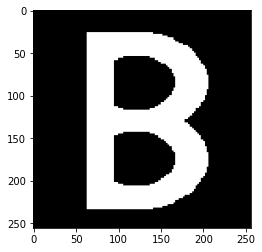

In [82]:
path = "/content/drive/My Drive/Colab Notebooks/MA202/TP1 Segmentation image/images/"
imp_paths = ["alfa2.bmp", "beee2.bmp", "cible2.bmp", "city2.bmp", "country2.bmp", "promenade2.bmp", "veau2.bmp", "zebre2.bmp"]

import matplotlib.image as mpimg
img = cv.imread(path+imp_paths[1], cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
print(img.shape)

Nous utiliserons ici le parcours de Peano afin de transformer une image 2D et un vecteur 1D pour le traitement et la segmentation

On crée une fonction qui va appliquer toutes les étapes nécessaires à la segmentation d'image.
<br/>
Notons que dans notre cas, nous disposons d'images de bonnes qualité que nous bruitons nous même : cela nous permet de calculer les taux d'erreur, d'apprécier l'influence du bruit sur les performances. <br/>
Nous disposons d'images de types variés (avec détails, sans trop de détails, applats de couleur, zones distinctes), cela nous permettra de discuter des performances de nos algorithmes dans des contextes variés.

In [0]:
def reconstruction(img, w, m_bruit, sig_bruit, iter = 10, display=False) :
  # === BRUITAGE ===
  img1D= peano_transform_img(img)
  noisy_img1D = bruit_gauss(img1D, w, m_bruit[0], sig_bruit[0], m_bruit[1], sig_bruit[1])
  noisy_img = transform_peano_in_img(noisy_img1D, 256)
  reconstructed = transform_peano_in_img(img1D, 256)
  if display :
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Image bruitée')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('reconstructed')

  # === ESTIMATION GM ===
  p0 = np.array([.25, .75])
  A0 = np.array([[.8, .2], [.07, .93]])
  m10 = 2
  m20 = 3
  sig10 = 1
  sig20 = 3
  p_est_GM, m1_est_GM, sig1_est_GM, m2_est_GM, sig2_est_GM = estim_param_EM_gm(iter, noisy_img1D, p0, m10, sig10, m20, sig20)

  # === ESTIMATION CMC ===
  #p_est_CMC, A_est_CMC, m1_est_CMC, sig1_est_CMC, m2_est_CMC, sig2_est_CMC = estim_param_EM_mc_alternatif( noisy_img1D, p0, A0, m10, sig10, m20, sig20)
  p_est_CMC, A_est_CMC, m1_est_CMC, sig1_est_CMC, m2_est_CMC, sig2_est_CMC = estim_param_EM_mc(iter, noisy_img1D, p0, A0, m10, sig10, m20, sig20)

  # === SEGMENTATION GM ===
  img_seg_gm_1D = mpm_gm(noisy_img1D, w, p_est_GM, m1_est_GM, sig1_est_GM, m2_est_GM, sig2_est_GM)
  terr_GM = sum(img_seg_gm_1D != img1D)/img1D.size
  #print("taux d'erreur GM = {:.2%}".format(terr_GM))

  # === SEGMENTATION CMC ===
  img_seg_cmc_1D = mpm_mc(noisy_img1D, w, p_est_CMC, A_est_CMC, m1_est_CMC, sig1_est_CMC, m2_est_CMC, sig2_est_CMC)
  terr_CMC = sum(img_seg_cmc_1D != img1D)/img1D.size
  #print("taux d'erreur CMC = {:.2%}".format(terr_CMC))


  # === RECONSTRUCT ===
  img_GM = transform_peano_in_img(img_seg_gm_1D, 256)
  img_CMC = transform_peano_in_img(img_seg_cmc_1D, 256)
  if display :
    # === PLOTS === 
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.imshow(img,cmap='gray')
    plt.title("Image d'origine")
    plt.subplot(2, 2, 2)
    plt.imshow(noisy_img, cmap='gray')
    plt.title("image bruitée")
    plt.subplot(2, 2, 3)
    plt.imshow(img_GM, cmap='gray')
    plt.title("Segmentation GM, precision = {:.2%}".format(np.round(1-terr_GM, 2)))
    plt.subplot(2, 2, 4)
    plt.imshow(img_CMC, cmap='gray')
    plt.title("Segmentation CMC, precision = {:.2%}".format(np.round(1-terr_CMC, 2)))
    plt.show()
  return img_CMC, terr_CMC, img_GM, terr_GM, noisy_img

Les résultats des CMC sont très satisfaisants et dépassent ceux des GM. Les temps de calcul sont raisonnables. <br/>
Un point d'interrogation reste sur la condition d'arrêt des estimateurs des paramètres CMC, on s'arrête avec un certain nombre d'itérations. Il serait peut être plus judicieux de s'arrêter une fois que l'on a atteint une certaine stabilité des résultats (ex $||\theta_{N+1}|| - ||\theta_n|| < 0.05$)
<br/><br/>

On observe des erreurs plus importantes en CMC lorsque les images possèdent des pattern irréguliers (exemple du zèbre qui a des rayures de tailles différents, écartées de façon irrégulières entre son cou et ses pattes (moins bien segmentés) et son ventre (plutot bien segmenté). Ici, il serait peut-être judicieux d'avoir recours à des triplets markoviens (TMC) afin de prendre en compte ces non stationnarités. Par exemple avec le zèbre, il y aurait un pattern cou/jambes, un ventre et un arrière plan qui tiendrait compte des distributions différentes.




Affichons nos résultats : 

In [0]:
def illustre() :
  w = np.array([0, 255])
  m1 = [0, 3]
  sig1 = [1, 2]
  m2 = [1, 1]
  sig2 = [1, 5]
  m3= [1, 0]
  sig3=[1, 1]
  for i in range(8) :
    img = cv.imread(path+imp_paths[i], cv.IMREAD_GRAYSCALE)
    cmc1, cmc_err1, gm1, gm_err1, noisy_img1 = reconstruction(img, w, m1, sig1,iter=5)
    cmc2, cmc_err2, gm2, gm_err2, noisy_img2 = reconstruction(img, w, m2, sig2,iter=5)
    cmc3, cmc_err3, gm3, gm_err3, noisy_img3 = reconstruction(img, w, m3, sig3,iter=5)

    # === PLOTS === 
    plt.figure(figsize=(5,3))
    plt.imshow(img,cmap='gray')
    plt.title("Image d'origine : ")
    plt.show()

    plt.figure(figsize=(15,10))
    plt.subplot(3, 3, 1)
    plt.imshow(noisy_img1, cmap='gray')
    plt.title("image bruitée avec bruit 1")
    plt.subplot(3, 3, 2)
    plt.title("Segmentation GM, precision = {:.2%}".format(np.round(1-gm_err1, 2)))
    plt.imshow(gm1, cmap='gray')
    plt.subplot(3, 3, 3)
    plt.imshow(cmc1, cmap='gray')
    plt.title("Segmentation CMC, precision = {:.2%}".format(np.round(1-cmc_err1, 2)))

    plt.subplot(3, 3, 4)
    plt.imshow(noisy_img2, cmap='gray')
    plt.title("image bruitée avec bruit 2")
    plt.subplot(3, 3, 5)
    plt.title("Segmentation GM, precision = {:.2%}".format(np.round(1-gm_err2, 2)))
    plt.imshow(gm2, cmap='gray')
    plt.subplot(3, 3, 6)
    plt.imshow(cmc2, cmap='gray')
    plt.title("Segmentation CMC, precision = {:.2%}".format(np.round(1-cmc_err2, 2)))

    plt.subplot(3, 3, 7)
    plt.imshow(noisy_img3, cmap='gray')
    plt.title("image bruitée avec bruit 3")
    plt.subplot(3, 3, 8)
    plt.title("Segmentation GM, precision = {:.2%}".format(np.round(1-gm_err3, 2)))
    plt.imshow(gm3, cmap='gray')
    plt.subplot(3, 3, 9)
    plt.imshow(cmc3, cmap='gray')
    plt.title("Segmentation CMC, precision = {:.2%}".format(np.round(1-cmc_err3, 2)))

    plt.show()
    

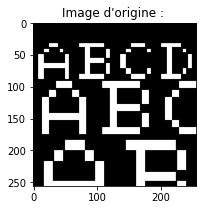

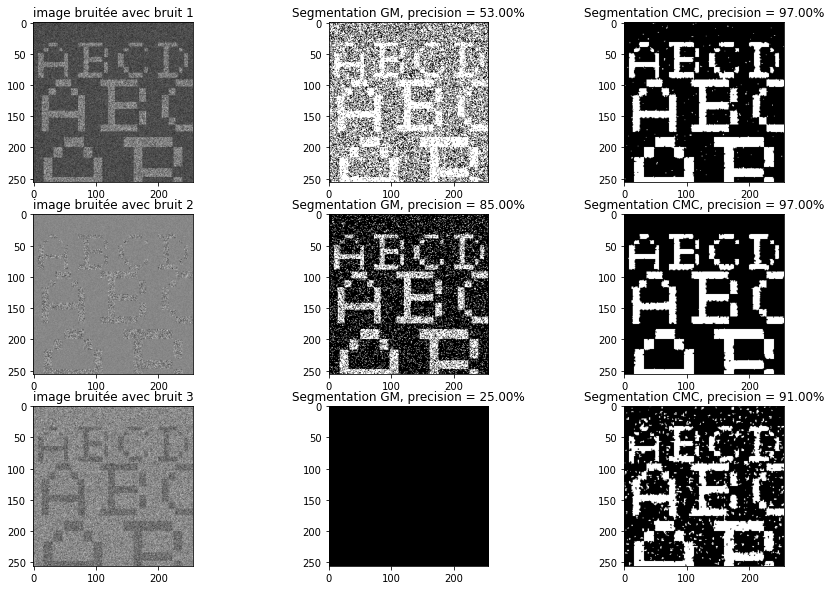

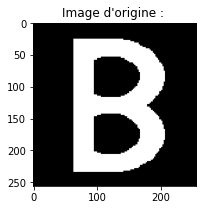

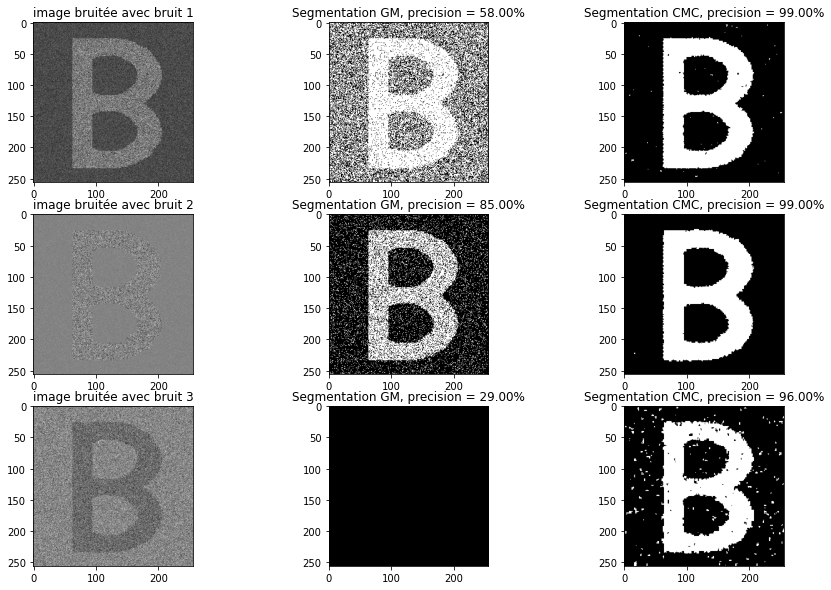

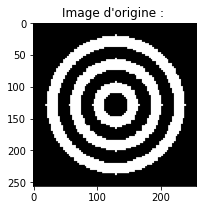

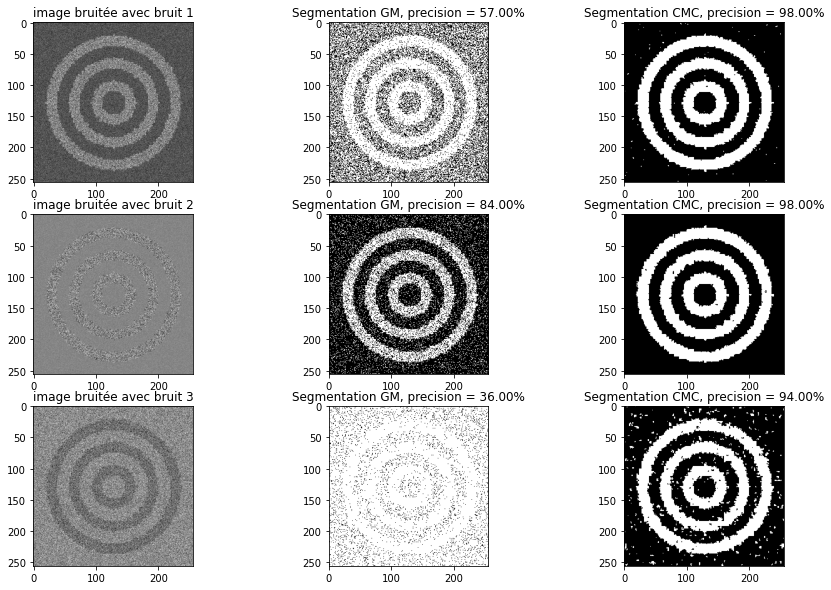

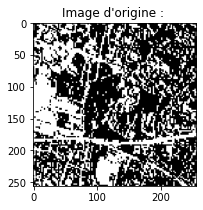

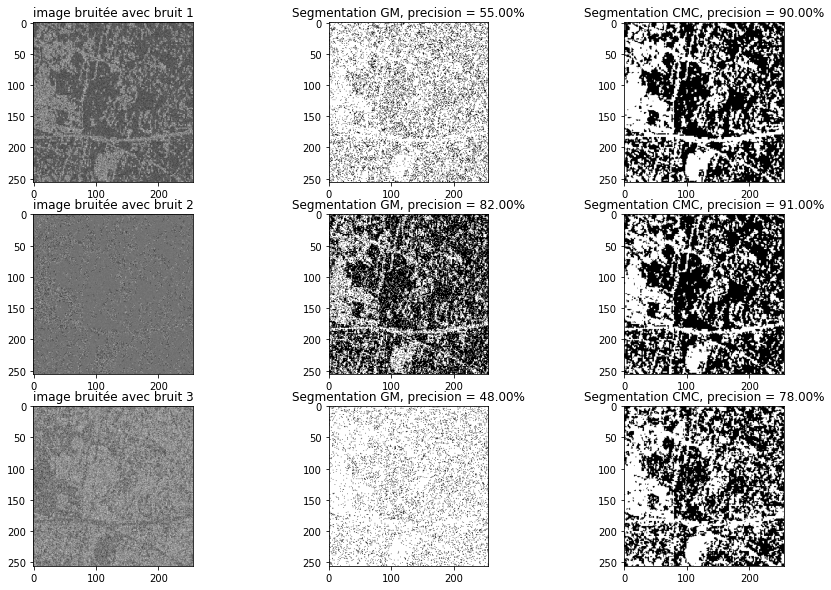

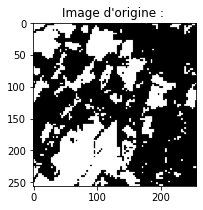

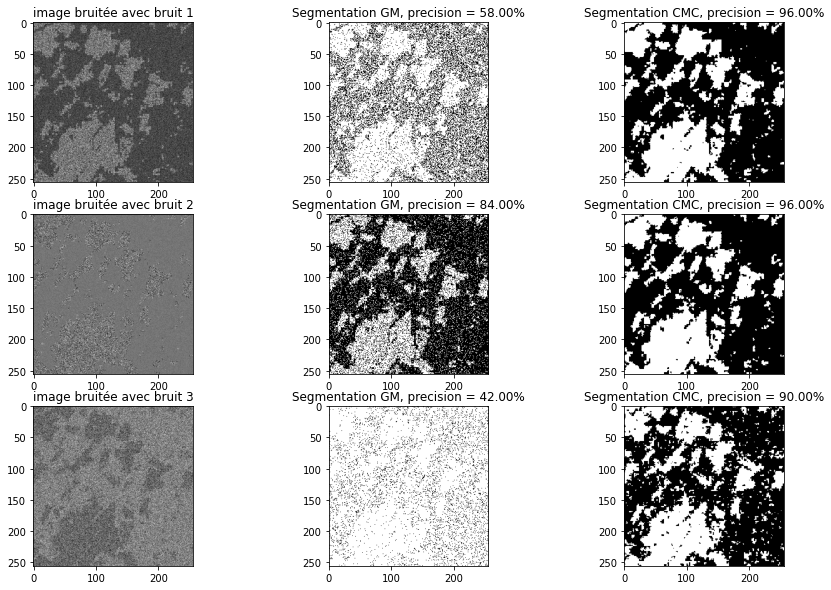

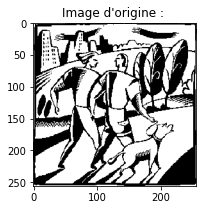

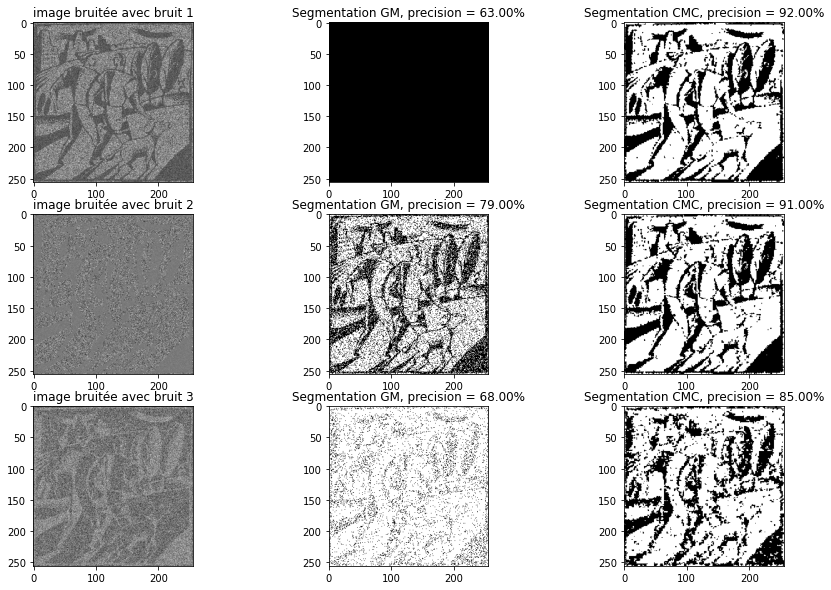

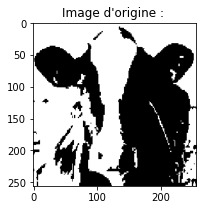

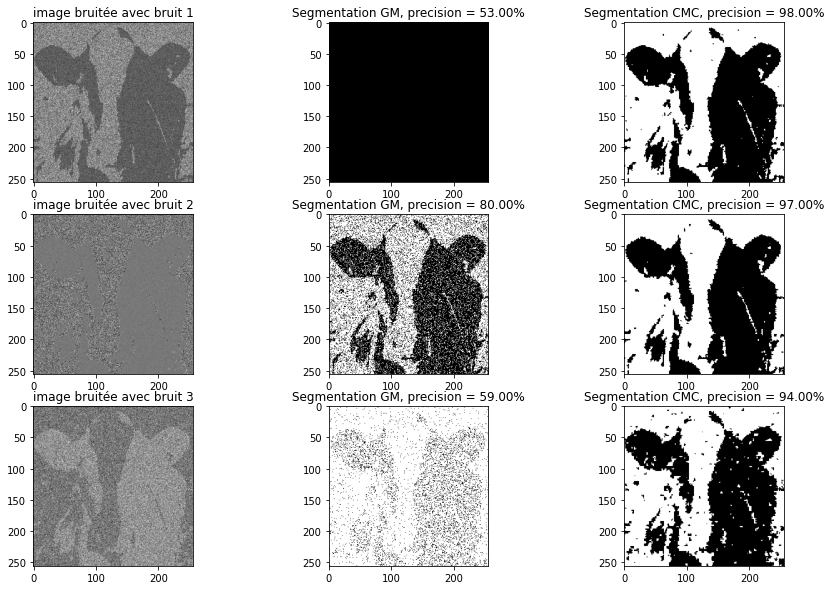

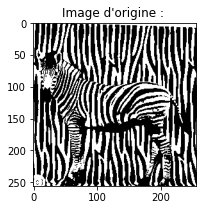

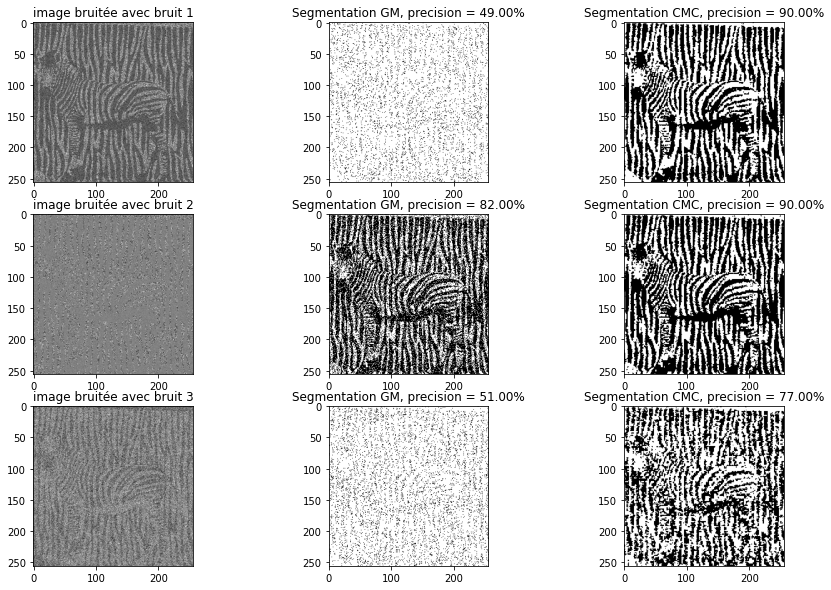

In [95]:
illustre()

On remarque une baisse assez importante de la précision lorsque les bruits correspondants aux deux classes sont proches (cas du bruit 3 avec des moyennes proches (0 et 1) et des variances identiques), cependant les CMC sont beaucoup plus robustes que le modèle indépendant. Dans le cadre bruit n°3, c'est à dire des bruit très proches, le modèle indépendant a des performances vraiment médiocres, en dessous des 50%, parfois moins soit pire qu'une prédiction aléatoire...

# Conclusion :
Au cours de ce TD nous avons mis en place une stratégie de **segmentation bayésienne non supervisée** utilisant l'estimateur **MPM** et en comparant deux modélisations de dépendances entre les couples (Xi, Yi) : le modèle *CMC* et le *Modèle Indépendant*. <br/>
Le CMC est un modèle très simplifié de la réalité. Cela permet donc une implémentation informatique simple de la modélisation des dépendances et une complexité algorithmique assez limitée (contrairement aux solutions de réseaux bayésiens typiquement). Ce modèle qui offre des **performances supérieures** au modèle indépendant et semble **bien plus robuste**. Le gain en performance du CMC sur le modèle indépendant peut aller jusqu'à 40% dans les cas les plus extrêmes !<br/>
Les performances CMC avoisinent les 95% en moyenne. <br/>
Notons tout de même des cas assez caractéristiques où les CMC ont plus de mal : il s'agit des images présentant des zones distinctes (promenade, city, country et zèbre) où il faudrait avoir plusieurs matrices de transitions. Cela illustre parfaitement les limites des CMC face à la non stationnarité des données. Limite qui motive donc l'implémentation des chaînes de markov triples notamment. 

